In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-03-19 17:51:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.66.144, 142.250.207.80, 172.217.24.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.66.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  10.7MB/s    in 6.1s    

2022-03-19 17:51:35 (10.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [1]:
# unzip dataset from tmp/cats_and_dogs_filtered.zip

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/cats_and_dogs_filtered')
zip_ref.close()


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/cats_and_dogs_filtered.zip'

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

In [2]:
# create transform for data augmentation: normalize, and convert to tensor
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
size = 256
data_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std),transforms.CenterCrop(size)])

# get root directory and label mapping
data_dir = '/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/cats_and_dogs_filtered'
label_dir = os.listdir(data_dir + '/train/')
label_mapping = {label_dir[i]: i for i in range(len(label_dir))}

# define hyperparameters
batch_size = 32
num_epochs = 10

#show image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
#create dataset class for cats and dogs


class catsdogsDataset(Dataset):
    def __init__(self, root_dir, label_mapping, transform=None):
        # get root directory
        self.root_dir = root_dir
        # get transform
        self.transform = transform
        # get list of label from directory under root_dir
        self.label_dir = os.listdir(root_dir)
        self.data = pd.DataFrame(columns=['image_name', 'label'])
        # loop through each label and store list of image name and corresponding label
        for label in self.label_dir:
            self.data['image_name'] = os.listdir(os.path.join(root_dir, label))
            self.data['label'] = label
            self.data['labelmap'] = label_mapping[label]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data.iloc[idx, 1], self.data.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.data.iloc[idx,2]
                
        if self.transform:
            image = self.transform(image)
            
        return image,label

In [4]:
# send device to gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
train_dataset = catsdogsDataset(root_dir='/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/cats_and_dogs_filtered/train',label_mapping = label_mapping, transform=data_transforms)
test_dataset = catsdogsDataset(root_dir='/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/cats_and_dogs_filtered/validation',label_mapping = label_mapping, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([32, 3, 256, 256])
<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


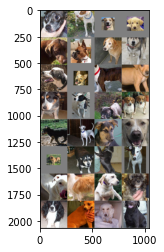

In [6]:
for i, (images,labels) in enumerate(train_loader):
    print(images.shape)
    print(type(images))
    print(labels)
    imshow(utils.make_grid(images, nrow=4))
    break


In [10]:
# Define network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.maxpool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*16*16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def foward(self,x):
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = self.maxpool3(F.relu(self.conv3(x)))
        x = self.maxpool4(F.relu(self.conv4(x)))
        x = x.view(-1, 256*16*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# create model, loss function, optimizer
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# train model with standard epoch loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, n_total_steps, loss.item()))

NotImplementedError: 